# Exploring the DANDI Archive

This notebook serves as a quick-start guide for the [Distributed Archive for Neurophysiology Data Integration (DANDI)](https://registry.opendata.aws/dandiarchive/).

<div style="background:#fff2cc; border:1px solid #000000; border-radius:2px; padding:2px 5px; margin:-5px 0 5px 20px;
color:#000000;
display:inline-block; ">
    <div style="font-weight:bold;">ℹ️ Definition</div>
    A <i>Dandiset</i> is a collection of neurophysiology data and metadata hosted on the <a
    href="https://dandiarchive.org" style="font-weight:bold;">DANDI Archive</a>.
</div>

The DANDI Archive holds hundreds of Dandisets with a diverse range of neurodata modalities.

These modalities span the spectrum of microscopy, optogenetics, intracellular and extracellular
electrophysiology, and optophysiology.

While we cannot hope to completely showcase this diversity here, there are two key examples which provide a good
starting point:
- [000728 - Visual Coding - Optical Physiology](https://dandiarchive.org/dandiset/000728/) by the Allen Institute for
Brain Science (AIBS)
- [000409 - Brain Wide Map](https://dandiarchive.org/dandiset/000409/) by the International Brain Laboratory (IBL)

For even more [usage guides](https://docs.dandiarchive.org/user-guide-using/exploring-dandisets/),
[dandiset-specific tutorials](https://dandi.github.io/example-notebooks/), and general documentation, please read the
main [DANDI Docs](https://docs.dandiarchive.org/).

### Q: How do I navigate the archive and its datasets?

DANDI provides a [web interface](https://dandiarchive.org/dandiset), [REST API](https://api.dandiarchive.org/api/docs/swagger/),
and [command-line interface (CLI)](https://pypi.org/project/dandi/) to help users intuitively navigate the contents.

The easiest place to start is the primary [Dandiset listing page](https://dandiarchive.org/dandiset).

After scrolling around a while, we choose our first Dandiset from the web interface [000728](https://dandiarchive.org/dandiset/000728/0.240827.1809).

We can see the contents by going to the ["Files" tab](https://dandiarchive.org/dandiset/000728/0.240827.1809/files).

From here, we can see that a Dandiset is organized as a collection of folders organized by subject ID.

Each folder contains files named according to session ID or other unique discriminators:

```text
000728/
├── sub-691657859/sub-691657859_ses-712919679-StimB_ophys.nwb
│   ├── sub-691657859_ses-712919679-StimB_ophys.nwb
│   ├── sub-691657859_ses-710504563-StimA_behavior+image+ophys.nwb
│   └── ...
├── sub-501800590/
│   └── ...
└──...
```

### Setup

Before we start accessing data contents, we will need to install and import some Python libraries:

In [45]:
!pip install -q dandi matplotlib remfile opencv-python-headless

from pathlib import Path

import cv2
import h5py
import remfile
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import read_nwb, NWBHDF5IO

Next, we will initialize our DANDI API client to interact with the archive database and list a few of the
available Dandisets:

In [46]:
client = DandiAPIClient()
dandisets = list(client.get_dandisets())

# Print the dandiset IDs and titles of the first 3 dandisets
for dandiset in dandisets[:3]:
    print(f"{dandiset.identifier}: {dandiset.get_raw_metadata()["name"]}")

000003: Physiological Properties and Behavioral Correlates of Hippocampal Granule Cells and Mossy Cells
000004: A NWB-based dataset and processing pipeline of human single-neuron activity during a declarative memory task
000005: Electrophysiology data from thalamic and cortical neurons during somatosensation


Now let's return to our first example Dandiset and list out a few of its contents:

In [47]:
dandiset = client.get_dandiset(dandiset_id="000728", version_id="0.240827.1809")
assets = list(dandiset.get_assets())

# Print the file paths as seen on the DANDI web interface
for asset in assets[:3]:
    print(asset.get_raw_metadata()["path"])

sub-691657859/sub-691657859_ses-712919679-StimB_ophys.nwb
sub-501800590/sub-501800590_ses-509522931-StimC_ophys.nwb
sub-572569275/sub-572569275_ses-591563201-StimB_ophys.nwb


<div style="background:#cfe2f3; border:1px solid #000000; border-radius:2px; padding:2px 5px; color:#000000;
display:inline-block;">
    <div style="font-weight:bold;">💡 Info</div>
    <div style="margin-top:5px;">
        Notice that we passed a <code style="background:#cfe2f3; color:#000000">version_id</code> in this case.
        Dandisets that are published on the archive are given a citable DOI, such as:
    </div>
    <div style="padding-left:20px; margin:5px 0;">
        Allen Institute (2024) <em>Allen Institute - Visual Coding - Optical Physiology</em> (Version 0.240827.1809)
        [Data set]. DANDI archive.<br><a href="https://doi.org/10.48324/dandi.000728/0.240827.1809"
        style="font-weight:bold;">DOI: 10.48324/dandi.000728/0.240827.1809</a>
    </div>
    <div>These citations should be used in any scientific reuse of the data.</div>
    <div style="margin-top:5px;">
        Otherwise, the most recent 'draft' state of the Dandiset is used by default and is subject to change by the Dandiset contributors.
    </div>
</div>

<div style="background:#e9e2f8; border:1px solid #000000; border-radius:2px; padding:2px 5px; color:#000000;
display:inline-block; ">
    <div style="font-weight:bold;">🧠 Learn more</div>
    You may have also noticed that in several cases above, we fetched the metadata associated with the Dandisets and
    their assets.
    <br>
    These are very rich models whose full potential is best showcased in the <a href="https://docs.dandiarchive
    .org/example-notebooks/tutorials/cosyne_2023/advanced_asset_search/#going-beyond" style="font-weight:bold;">Advanced Search Tutorial</a>.
</div>

### Q: What kinds of data are hosted and what formats do they use?

DANDI accepts a relatively small number of open, community-driven file formats designed according to NIH-accepted
data standards*.

<div style="display: block; width: 100%;">
<div style="margin-left: 0; margin-right: auto; display: table;">

|                                         <center>Data Standard</center>                                          | <center>Acronym</center>  |                 <center>Domain</center>                  |    <center>Data Format(s)</center>    |
|:---------------------------------------------------------------------------------------------------------------:|:-------------------------:|:--------------------------------------------------------:|:-------------------------------------:|
|                         <center>[Neurodata Without Borders](https://nwb.org/)</center>                          |   <center>NWB</center>    |     <center>Neurophysiology<br>and behavior</center>     |     <center>HDF5<br>Zarr</center>     |
|                 <center>[Brain Imaging Data Structure](https://bids.neuroimaging.io/)</center>                  |   <center>BIDS</center>   |    <center>Neuroimaging<br>(MRI, EEG, etc.)</center>     | <center>NIfTI<br>JSON<br>TSV</center> |
|    <center>[Open Microscopy Environment](https://docs.openmicroscopy.org/ome-model/5.6.3/ome-tiff/)</center>    | <center>OME-TIFF</center> |           <center>Microscopy imaging</center>            |         <center>TIFF</center>         |
| <center>[Open Microscopy Environment<br>Next Generation File Format](https://ngff.openmicroscopy.org/)</center> | <center>OME-Zarr</center> | <center>Microscopy imaging<br>(cloud-optimized)</center> |         <center>Zarr</center>         |

</div>
</div>

These data standards are specifically designed to integrate multi-modal raw and processed neurodata alongside
behavioral data and metadata annotations.

The S3 bucket hosting the DANDI archive allows users to take advantage of cloud-native
services for scalable data access, computation, visualization, and analysis.

This allows DANDI to integrate with many external visualization tools, accessible via the "Open With" button on the
web interface.

- [NWB: Neurosift](https://neurosift.app)
    - [Example: 000728/sub-495727000/sub-495727000_ses-51254258-StimC_behavior+image+ophys.nwb](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/0205b9b1-10c4-467c-b027-20bbbfcce3a0/download/&dandisetId=001172&dandisetVersion=0.260129.0829)
- [OME: Neuroglancer](https://github.com/google/neuroglancer)
    - [Example: 000026/sub-I58/ses-Hip-CT/micr/](https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22z%22:%5B0.00001513%2C%22m%22%5D%2C%22y%22:%5B0.00001513%2C%22m%22%5D%2C%22x%22:%5B0.00001513%2C%22m%22%5D%7D%2C%22position%22:%5B5257.03564453125%2C4706%2C4218.56396484375%5D%2C%22crossSectionScale%22:21.48356465187443%2C%22projectionScale%22:16384%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22https://dandiarchive.s3.amazonaws.com/zarr/5c37c233-222f-4e60-96e7-a7536e08ef61%22%2C%22tab%22:%22rendering%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B23257%2C24764%5D%2C%22window%22:%5B22877%2C25144%5D%7D%7D%2C%22name%22:%22798b8b1b-c88d-42e8-91f8-247fd4282fe7%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22798b8b1b-c88d-42e8-91f8-247fd4282fe7%22%7D%2C%22layout%22:%224panel%22%7D)

<div style="background:#e9e2f8; border:1px solid #000000; border-radius:2px; padding:2px 5px; margin:25px 0 5px 0px;
color:#000000;
display:inline-block; ">
    <div style="font-weight:bold;">🧠 Learn more</div>
    <div style="margin-top:2px;">
        For readers interested in exploring more tools compatible with DANDI-supported data formats, refer to:
    </div>
    <ul style="margin-top:5px; margin-bottom:5px;">
        <li><a href="https://nwb-overview.readthedocs.io/en/latest/tools/analysis_tools_home.html#analysis-and-visualization-tools" style="font-weight:bold;">NWB: Analysis Tools</a></li>
        <li><a href="https://bids.neuroimaging.io/tools/others.html#analysis" style="font-weight:bold;">BIDS: Analysis Tools</a></li>
    </ul>
</div>

*The difference between data formats and standards is elaborated in greater detail in the [Data
Standards](https://docs.dandiarchive.org/getting-started/data-standards/#data-standards) section of the documentation.

### Q: How do I access the contents of a Dandiset?

Data assets from a Dandiset can either be downloaded directly [from the web page](https://docs.dandiarchive.org/user-guide-using/accessing-data/downloading/#download-specific-files), [through the
CLI](https://docs.dandiarchive.org/user-guide-using/accessing-data/downloading/#using-the-python-cli-client),
or programmatically:

In [48]:
# Look up a specific file asset from a different Dandiset
dandiset = client.get_dandiset(dandiset_id="000728")
dandi_filename = "sub-495727015/sub-495727015_ses-501559087-StimB_behavior+image+ophys.nwb"
asset = dandiset.get_asset_by_path(path=dandi_filename)

# Download the entire file (alter the base directory as needed)
output_path = Path.cwd() / Path(dandi_filename).name
if not output_path.exists():
    asset.download(filepath=output_path)

To open the file after the download completes, we can use the [PyNWB](https://pynwb.readthedocs.io/en/stable/)
library to read the NWB file and display the basic content layout:

In [49]:
nwbfile = read_nwb(path=output_path)
print(nwbfile)

root pynwb.file.NWBFile at 0x1491548314544
Fields:
  data_collection: Generated by pipeline Brain Observatory version 3.0.
  devices: {
    Camera <class 'pynwb.device.Device'>,
    Microscope <class 'pynwb.device.Device'>,
    StimulusDisplay <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: For more information, please see http://help.brain-map.org/display/observatory/Allen+Brain+Observatory
  file_create_date: [datetime.datetime(2024, 3, 19, 15, 55, 50, 497145, tzinfo=tzoffset(None, -14400))]
  identifier: 211c0e3c-4b28-4375-b539-cdb71a42851b
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Brain Science
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  notes: Container ID: 511510736
Mouse ID (from genotype white paper): 222426
Session type: three_session_B
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class '

<div style="background:#cfe2f3; border:1px solid #000000; border-radius:2px; padding:2px 5px;
color:#000000; display:inline-block;">
    <div style="font-weight:bold;">💡 Info</div>
    In this type of experiment, a location in the brain is recorded by a microscope in real time while the neurons or
    other cells emit light corresponding to their activity.
</div>

<div style="background:#e9e2f8; border:1px solid #000000; border-radius:2px; padding:2px 5px;color:#000000;display:inline-block; ">
    <div style="font-weight:bold;">🧠 Learn more</div>
    <div style="margin-top:2px;">
        Here, the molecule that emits light is a calcium indicator, which fluctuates in proportion to the number of
        action potentials fired by the neurons.
        <br><br>
        If you are interested in learning more about two-photon calcium imaging, or have any questions about the rest
        of this experiment, check out the <a href="https://alleninstitute.github.io/openscope_databook/basics/background.html#understanding-data-collection-techniques" style="font-weight:bold;">OpenScope Databook</a>.
    </div>
</div>

A common way of analyzing fluorescence imaging data is to quantify the change in the amount of light emitted by
specific regions.

One such measure is the $\Delta F/F$ time series, which is derived from the raw two-photon calcium imaging.

This data stream can be found under the 'processing' module:

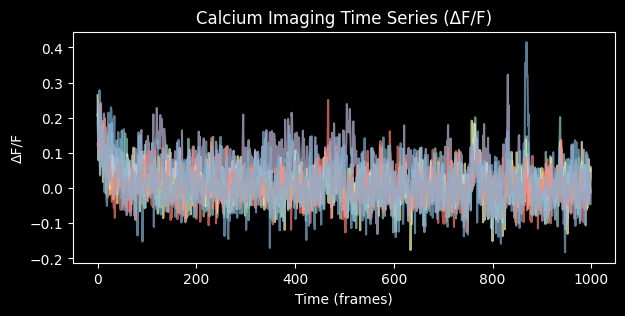

In [50]:
df_over_f_array = nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].data

# Get a subset of the data for visualization
# Note that the `df_over_f_array` has shape `number of frames x number of regions of interest (ROI)`
# reflecting the dimensions of `time x ROIs`
time_series_data = df_over_f_array[:1000, :5]

plt.figure(figsize=(7, 3))
for i in range(time_series_data.shape[1]):
    plt.plot(time_series_data[:, i], alpha=0.7)

plt.xlabel('Time (frames)')
plt.ylabel('ΔF/F')
plt.title('Calcium Imaging Time Series (ΔF/F)')
plt.show()

<div style="background:#cfe2f3; border:1px solid #000000; border-radius:2px; padding:2px 5px; margin:5px 0 5px 0px;
color:#000000; display:inline-block;">
    <div style="font-weight:bold;">💡 Info</div>
    All data access when reading from an NWB file is 'lazy' in the sense that data arrays are not read into memory
    until explicitly requested via slicing operations.
    <br>
    This is particularly useful when working with large (> 60 GB) datasets that may not otherwise fit into
    memory.
</div>

Some files on the DANDI archive can be quite large - even hundreds of gigabytes - which makes downloading a
file just to explore its contents impractical.

Thankfully, instead of downloading, you can [stream data directly from S3](https://docs.dandiarchive.org/example-notebooks/tutorials/bcm_2024/analysis-demo/#streaming-and-interacting-with-nwb-data-from-dandi)!

Let's give that a try:

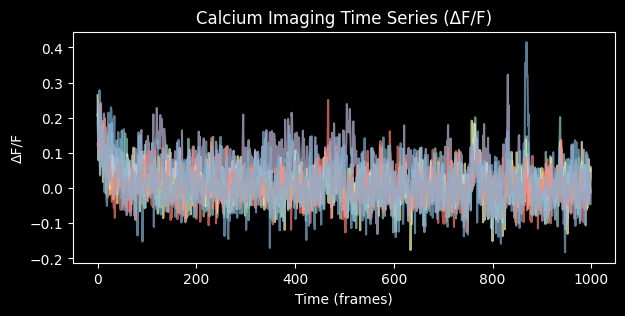

In [51]:
s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
rem_file = remfile.File(url=s3_url)
h5py_file = h5py.File(name=rem_file, mode="r")
io = NWBHDF5IO(file=h5py_file)
streamed_nwbfile = io.read()

streamed_df_over_f_array = streamed_nwbfile.processing["ophys"]["DfOverF"]["DfOverF"].data

streamed_time_series_data = streamed_df_over_f_array[:1000, :5]

plt.figure(figsize=(7, 3))
for i in range(streamed_time_series_data.shape[1]):
    plt.plot(streamed_time_series_data[:, i], alpha=0.7)

plt.xlabel('Time (frames)')
plt.ylabel('ΔF/F')
plt.title('Calcium Imaging Time Series (ΔF/F)')
plt.show()

While we just showcased a simple data array, DANDI assets can also include beautiful images and videos!

Now let's get a better understanding of how the identified regions of interest relate to our underlying imaging data.

These data streams can be accessed and displayed in nearly the same manner:

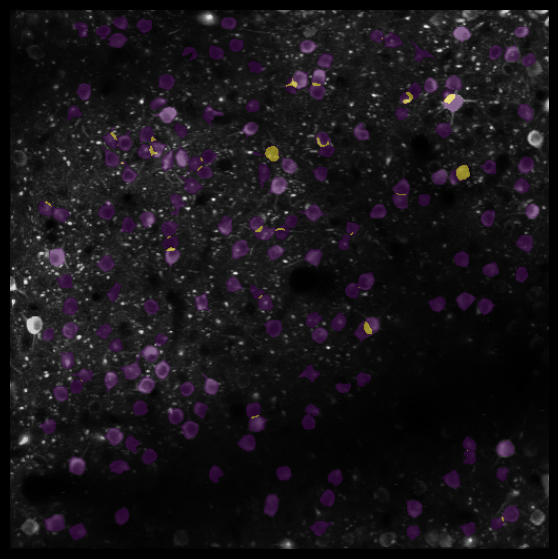

In [52]:
summary_image = nwbfile.processing["ophys"]["SummaryImages"]["maximum_intensity_projection"][:]
plane_segmentation = nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]

combined_image_masks = np.zeros(shape=summary_image.shape)
for pixel_mask in plane_segmentation["pixel_mask"][:]:
    for x, y, w in pixel_mask:
        combined_image_masks[x,y] += w
masked_image = np.ma.masked_where(combined_image_masks == 0, combined_image_masks)

plt.figure(figsize=(7, 7))
plt.imshow(summary_image, cmap="gray")
plt.imshow(masked_image, cmap="viridis", alpha=0.5)
plt.axis('off');

The gray background represents the imaging space, while the colored overlay indicates the
identified regions where neural activity was measured.

As mentioned, DANDI hosts a diverse range of neurophysiology data modalities - not just optophysiology!

Let's also showcase some electrophysiology and behavioral data:

In [53]:
# Setup streaming like we did before
ecephys_dandiset = client.get_dandiset("000409", "draft")

subject_id = "sub-NYU-39"
session_id = "ses-6ed57216-498d-48a6-b48b-a243a34710ea"
ecephys_path = f"{subject_id}/{subject_id}_{session_id}_desc-processed_behavior+ecephys.nwb"
ecephys_asset = ecephys_dandiset.get_asset_by_path(path=ecephys_path)

ecephys_s3_url = ecephys_asset.get_content_url(follow_redirects=1, strip_query=True)
ecephys_rem_file = remfile.File(url=ecephys_s3_url)
ecephys_h5py_file = h5py.File(name=ecephys_rem_file, mode="r")
ecephys_io = NWBHDF5IO(file=ecephys_h5py_file)
ecephys_nwbfile = ecephys_io.read()

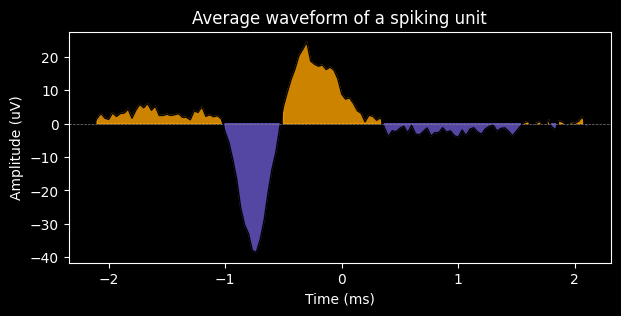

In [54]:
# Filter by 'good units' (those with non-NaN waveforms) and select one for visualization
units_dataframe = ecephys_nwbfile.units.to_dataframe()
good_unit = units_dataframe[
    [not np.isnan(row["waveform_mean"]).any() for _, row in units_dataframe.iterrows()]
].iloc[10]

# Extract waveform and convert from volts to microvolts
waveform_uV = good_unit["waveform_mean"] * 1e6
trace = waveform_uV[:, 19]

# Define the time axes of the waveform
num_samples = waveform_uV.shape[0]
sampling_rate = 30_000.0
time_ms = (np.arange(num_samples) - num_samples // 2) / sampling_rate * 1000

# Plot
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(time_ms, trace, color="black", linewidth=1.0)
ax.fill_between(time_ms, 0, trace, where=(trace > 0), color="orange", alpha=0.8)
ax.fill_between(time_ms, 0, trace, where=(trace < 0), color="slateblue", alpha=0.8)
ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Amplitude (uV)")
plt.title(f"Average waveform of a spiking unit")
plt.show()

<div style="background:#e9e2f8; border:1px solid #000000; border-radius:2px; padding:2px 5px; margin:25px 0 5px 0px;
color:#000000;
display:inline-block; ">
    <div style="font-weight:bold;">🧠 Learn more</div>
    <div style="margin-top:2px;">
        In this type of experiment, one or more <a href="https://www.neuropixels.org/" style="font-weight:bold;
        ">Neuropixels probes</a> were inserted
        into specific locations within the brain to record the electrical activity around clusters of neurons.
        <br><br>
        If you are interested in learning more about this experiment, check out the <a href="https://www
        .internationalbrainlab.com/brainwide-map"
         style="font-weight:bold;">International Brain Lab: The Brain-Wide Map</a> website.
    </div>
</div>

Alongside the recordings of neural activity, a video captures the animal performing the simple task of turning a wheel!

Various points on the body (such as hands and eyes) are then tracked using a technique known as 'pose estimation':

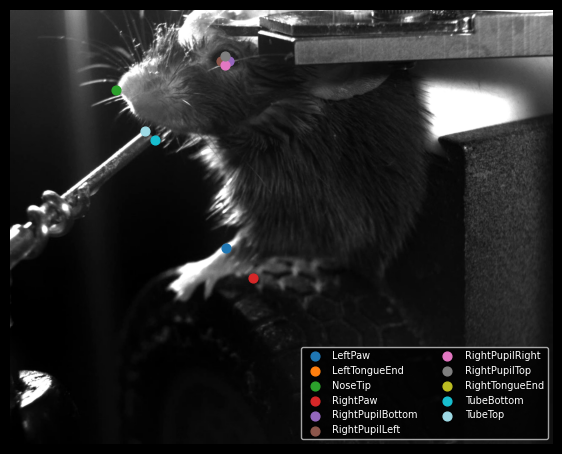

In [55]:
video_directory = f"{subject_id}/{subject_id}_{session_id}_behavior+ecephys+image"
video_path = f"{video_directory}/{subject_id}_{session_id}_OriginalVideoLeftCamera.mp4"
video_asset = ecephys_dandiset.get_asset_by_path(path=video_path)
video_s3_url = video_asset.get_content_url(follow_redirects=1, strip_query=True)

cap = cv2.VideoCapture(video_s3_url)
cap.set(cv2.CAP_PROP_POS_FRAMES, 100000)
_, frame = cap.read()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

pose_estimation_module = ecephys_nwbfile.processing["pose_estimation"]
left_camera_pose_estimation = pose_estimation_module["LeftCamera"]
pose_estimation_series = left_camera_pose_estimation.pose_estimation_series

plt.figure(figsize=(7, 6))
plt.imshow(frame_rgb)
colors = plt.cm.tab20(np.linspace(0, 1, len(pose_estimation_series)))
for color, keypoint in zip(colors, pose_estimation_series):
    series = pose_estimation_series[keypoint]
    first_frame_point = series.data[0, :]
    plt.scatter(
        first_frame_point[0],
        first_frame_point[1],
        label=series.name.replace("PoseEstimationSeries", ""),
        color=color,
        s=40,
        zorder=5,
    )

plt.legend(loc="lower right", fontsize=7, framealpha=0.8, ncol=2)
plt.axis("off")
plt.show()


### Q: What is one scientific question that has been answered using these data?

Focusing on the optophysiology example used above - the Visual Coding project by the Allen Institute - one question
that was addressed involves characterizing population-level response characteristics across
visual cortex.


Multiple stimuli (natural scenes, drifting gratings, static gratings) were presented to each subject over the course
of the experiment. Different structures within the visual cortex were targeted across subjects. The neural responses during each presentation were then characterized to
 show differing response properties across visual areas. This demonstrated that different cortical layers have distinct
 response properties and tuning characteristics. The experiments also quantified how correlated activity between
 neurons affects information coding by showed that noise correlations are stronger between neurons with similar tuning
 properties. Additional findings demonstrate that correlations are modulated by behavioral state (running vs.
 stationary movements).

A full reproducible analysis of this work can be found through its more detailed [tutorial notebook](https://github.com/dandi/example-notebooks/blob/master/000728/AllenInstitute/visual_coding_ophys_tutorial.ipynb).

### Q: What is one unanswered question that you think could be answered using these data?

One such question might be how do different visual cortical areas (V1, LM, AL, PM) coordinate their activity over time
during naturalistic scene viewing, and can we identify temporal "routing" patterns that predict behavioral state transitions?

While the Visual Coding dataset(s) have characterized individual area responses, differences across cell types, and
other correlations, the temporal dynamics of information flow between areas during natural scene processing remains
less explored - particularly how running vs. stationary states modulate inter-area communication.

This dataset is just one small part of the greater Allen Brain Observatory effort, which has seen considerable reuse
based on questions like these. You can read more about this project in the following publication:

> de Vries, S. E., Siegle, J. H., & Koch, C. (2023). Sharing neurophysiology data from the Allen Brain Observatory.
> Elife, 12, e85550. DOI: https://doi.org/10.7554/eLife.85550

It is worth mentioning in this context that the NWB group hosts a regular [NeuroDataReHack event](https://nwb.org/events/hck26-2026-janelia-ndrh/)
where researchers are brought together to work precisely on such questions of how to analyze existing datasets in
novel ways, rather than running entirely new experiments. Check the [NWB Events](https://nwb.org/events/) page and
sign up for the newsletter to stay informed about these kinds of events!